In [1]:
import gc
import os
import time
import math
from math import exp, log
from collections import Counter
from typing import List, Optional, Union

import numpy as np
import pandas as pd
import transformers
import torch
import heapq
from tqdm import tqdm

import random
import statistics
from collections import Counter
from dataclasses import dataclass
from typing import Any, Callable, List, Optional, Tuple, Union

import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from pprint import pprint

In [2]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

PAD_TOKEN_LABEL_ID = torch.nn.CrossEntropyLoss().ignore_index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class HuggingFaceModelLoader:
    def __init__(self, model_path: str, load_in_8bit: bool, device_map: str):
        self.model_path = model_path
        self.load_in_8bit = load_in_8bit
        self.device_map = device_map

    def load_model(self) -> transformers.PreTrainedModel:
        if self.load_in_8bit:
            if DEVICE.type != 'cuda':
                raise ValueError('8-bit quantization requires a CUDA device')

            quantization_config = transformers.BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="fp4",
                bnb_4bit_use_double_quant=False,
                bnb_4bit_compute_dtype=torch.float16,
            )

            model = transformers.AutoModelForCausalLM.from_pretrained(
                self.model_path,
                quantization_config=quantization_config,
                device_map=self.device_map
            )
        else:
            model = transformers.AutoModelForCausalLM.from_pretrained(
                self.model_path,
                torch_dtype=torch.float16 if DEVICE.type == 'cuda' else torch.float32,
                device_map=self.device_map
            )

        model.eval()
        return model


class HuggingFaceTokenizer:
    def __init__(self, model_path: str):
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_path, padding_side="right")
        self.bos_token = self.tokenizer.bos_token or self.tokenizer.cls_token
        self.eos_token = self.tokenizer.eos_token or self.tokenizer.sep_token
        if self.bos_token is None:
            self.bos_token = ""
        if self.eos_token is None:
            self.eos_token = ""

    def tokenize(self, texts: List[str]) -> dict:
        processed_texts = []

        for text in texts:
            combined_text = f"{self.bos_token}{text}{self.eos_token}"
            processed_texts.append(combined_text)

        model_inputs = self.tokenizer(
            processed_texts,
            return_tensors='pt',
            add_special_tokens=False,
            padding=True
        )

        if 'token_type_ids' in model_inputs:
            model_inputs.pop('token_type_ids')

        return model_inputs


class PerplexityCalculator:
    def __init__(self, model_loader, tokenizer, exp_mode=False):
        self.model = model_loader.load_model()
        self.tokenizer = tokenizer
        self.exp_mode = exp_mode
        self.loss_fct = torch.nn.CrossEntropyLoss(reduction='none')

    def get_perplexity(
        self,
        input_texts: Union[str, List[str]],
        batch_size: int = 32
    ) -> Union[float, List[float]]:

        single_input = isinstance(input_texts, str)
        input_texts = [input_texts] if single_input else input_texts

        loss_list = []
        num_texts = len(input_texts)
        batches = num_texts // batch_size + (num_texts % batch_size != 0)
        with torch.no_grad():
            for j in range(batches):
                start_idx = j * batch_size
                end_idx = (j + 1) * batch_size
                input_batch = input_texts[start_idx:end_idx]

                with torch.no_grad():
                    model_inputs = self.tokenizer.tokenize(input_batch)
                    model_inputs = {k: v.to(DEVICE) for k, v in model_inputs.items()}

                    output = self.model(**model_inputs, use_cache=False)
                    logits = output['logits']

                    label = model_inputs['input_ids']
                    if hasattr(self.model.config, 'pad_token_id') and self.model.config.pad_token_id is not None:
                        label[label == self.model.config.pad_token_id] = PAD_TOKEN_LABEL_ID

                    shift_logits = logits[..., :-1, :].contiguous()
                    shift_labels = label[..., 1:].contiguous()

                    token_loss = self.loss_fct(
                        shift_logits.view(-1, shift_logits.size(-1)),
                        shift_labels.view(-1)
                    ).view(len(logits), -1)

                    valid_length = (shift_labels != PAD_TOKEN_LABEL_ID).sum(dim=-1)
                    sequence_loss = torch.sum(token_loss, -1) / valid_length
                    loss_list.extend(sequence_loss.cpu().tolist())

        if self.exp_mode:
            ppl = [exp(i) for i in loss_list]
        else:
            ppl = loss_list

        return ppl[0] if single_input else ppl

In [3]:
class SimulatedAnnealing:
    def __init__(self, start_temp, end_temp, max_iterations, cost_fn, neighbor_fn, random_state):
        self.start_temp = start_temp
        self.end_temp = end_temp
        self.max_iterations = max_iterations
        self.cost_fn = cost_fn
        self.neighbor_fn = neighbor_fn
        random.seed(random_state)

    def _acceptance_probability(self, diff, temperature):
        if diff <= 0:
            return 1.0
        return exp(-diff/temperature)

    def _lower_temperature(self, temperature, iteration):
        t1 = self.end_temp + self.start_temp/(1 + math.log(iteration+1))
        t2 = self.start_temp + (self.end_temp - self.start_temp)*(iteration/self.max_iterations)
        return max(t1, t2)

    def _print_progress(
        self,
        iteration: int,
        best_solutions: List[List[str]],
        best_energies: List[float],
        current_solutions: List[List[str]],
        current_energies: List[float],
        temperature: float,
        start_time: float,
        spend_minute: int
    ) -> int:
        current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        elapsed_time = time.time() - start_time

        # Check if 60 seconds have passed since the last update
        if elapsed_time - 60 * spend_minute > 60:
            spend_minute += 1
            progress = iteration / self.max_iterations * 100  # Progress as percentage

            # Print progress in a structured format
            print("===== Simulated Annealing Progress =====")
            print(f"Time: {current_time}")
            print(f"Iteration: {iteration}/{self.max_iterations} ({progress:.2f}%)")
            print(f"Temperature: {temperature:.4f}")
            print(f"Elapsed Time: {elapsed_time:.2f} seconds")

            # Print best solutions and energies
            print("\nBest Solutions:")
            idx_items = np.argsort(best_energies)[:5]

            for i, idx in enumerate(idx_items):
                print(f"  Solution {i+1}: {best_solutions[idx]}")
            print("\nBest Energies:")
            print("  " + ", ".join(f"{best_energies[idx]:.4f}" for idx in idx_items))

            # Print current solutions and energies
            print("\nCurrent Solutions:")
            for i, solution in enumerate(current_solutions[:5]):
                print(f"  Solution {i+1}: {solution}")
            print("\nCurrent Energies:")
            print("  " + ", ".join(f"{energy:.4f}" for energy in current_energies[:5]))

            print("========================================\n")

        return spend_minute


    def solve_batch(self, text_list, max_minute=60):
        """
        Perform Simulated Annealing for multiple texts at once.
        """
        solutions = text_list[:]
        current_energies = self.cost_fn(solutions)

        best_solutions = solutions[:]
        best_energies = current_energies[:]

        log_energies = [[] for _ in range(len(text_list))]
        for i in range(len(text_list)):
            log_energies[i].append(current_energies[i])

        temperature = self.start_temp
        start_time = time.time()
        spend_minute = 0

        for iteration in range(self.max_iterations):
            # 1) Generate neighbors
            new_solutions = [self.neighbor_fn(sol) for sol in solutions]

            # 2) Calculate new energies in batch
            new_energies = self.cost_fn(new_solutions)

            # 3) Acceptance and update
            for i in range(len(text_list)):

                diff = new_energies[i] - current_energies[i]
                ap = self._acceptance_probability(diff, temperature)

                if random.random() < ap:
                    solutions[i] = new_solutions[i]
                    current_energies[i] = new_energies[i]

                if current_energies[i] < best_energies[i]:
                    best_solutions[i] = solutions[i][:]
                    best_energies[i] = current_energies[i]

            # 4) Lower temperature
            temperature = self._lower_temperature(temperature, iteration)

            # 5) Log current energies
            for i in range(len(text_list)):
                log_energies[i].append(current_energies[i])

            # 6) Print progress (extracted into separate method)
            spend_minute = self._print_progress(
                iteration,
                best_solutions,
                best_energies,
                solutions,
                current_energies,
                temperature,
                start_time,
                spend_minute
            )

            # 7) Early stop if temperature is below threshold
            if temperature <= self.end_temp or spend_minute >= max_minute:
                print("Exiting.")
                break

        print(f"Execution time: {time.time() - start_time:.4f}s")

        # Convert best solutions back to strings
        return best_solutions, best_energies, log_energies

In [4]:
import random
from typing import List

class TSPListOperations:
    @staticmethod
    def two_rotation(item: List[str]) -> List[str]:
        i, j = random.sample(range(len(item)), 2)
        # Rotate two elements: (i, j) -> (j, i)
        item[i], item[j] = item[j], item[i]
        return item
    
    @staticmethod
    def random_rotation(item: List[str]) -> List[str]:
        if len(item) < 2:
            return item

        start_idx, end_idx = sorted(random.sample(range(len(item)), 2))

        shift = random.randint(1, len(item) - 1)
        sublist = item[start_idx:end_idx + 1]

        shift = shift % len(sublist)  # Normalize shift within sublist length
        sublist = sublist[shift:] + sublist[:shift]

        item[start_idx:end_idx + 1] = sublist

        return item

    @staticmethod
    def random_insertion(item: List[str]) -> List[str]:
        if len(item) < 2:
            return item
        
        size = random.randint(2, min(8, len(item)))
        start = random.randint(0, len(item)-size-1)
        end = start + size

        if random.random() < 0.5:
            elem = item.pop(end)
            item.insert(start, elem)
        else:
            elem = item.pop(start)
            item.insert(end, elem)
        return item

    @staticmethod
    def shuffle_sublist(item: List[str]) -> List[str]:
        if len(item) < 2:
            return item

        size = random.randint(2, min(8, len(item)))
        start = random.randint(0, len(item) - size-1)
        end = start + size - 1
        random.shuffle(item[start:end + 1])
        return item

    @staticmethod
    def double_bridge_move(item: List[str]) -> List[str]:
        n = len(item)
        
        size_B = random.randint(1, 4)  
        size_C = random.randint(1, 2)  
        size_D = random.randint(1, 4)  
        
        size_A = random.randint(0, n - (size_B + size_C + size_D))
        size_E = n - (size_A + size_B + size_C + size_D)
        
        # (3) a, b, c, d 계산
        a = size_A
        b = a + size_B
        c = b + size_C
        d = c + size_D
     
        A = item[:a]
        B = item[a:b]
        C = item[b:c]
        D = item[c:d]
        E = item[d:]

        if random.choice([True, False]):
            B = B[::-1]
        if random.choice([True, False]):
            D = D[::-1]

        return A + D + C + B + E


In [5]:
def cost_fn(sols, batch_size=10):
  return scorer.get_perplexity(sols, batch_size=batch_size)

def neighbor_fn(arr: str, prefix: int = 0, suffix: int = 0) -> str:
    item = arr.split()
    operations = [
        TSPListOperations.two_rotation,
        TSPListOperations.random_rotation,
        TSPListOperations.random_insertion,
        TSPListOperations.shuffle_sublist,
        TSPListOperations.double_bridge_move,
    ]

    op = random.choice(operations)
    item_modified = item[:prefix] + op(item[prefix:len(item)-suffix]) + item[len(item)-suffix:]
    return ' '.join(item_modified)

In [6]:
model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
model_loader = HuggingFaceModelLoader(model_path=model_path, load_in_8bit=False, device_map='auto')
tokenizer = HuggingFaceTokenizer(model_path)
scorer = PerplexityCalculator(model_loader, tokenizer, exp_mode=True)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
def average_increment(current_T0, uphill_diffs, p0):
    epsilon = 1e-12

    total_temperatures = []
    for diff in uphill_diffs:
        exponent = -diff / (current_T0 + epsilon)
        exponent = max(min(exponent, 700), -700)
        temperature = math.exp(exponent)
        total_temperatures.append(temperature)
        
    avg_exp = sum(total_temperatures) / len(total_temperatures)
    return avg_exp - p0

def estimate_initial_temperature(uphill_diffs, p0=0.1):
    
    num_uphill_diffs = len(uphill_diffs)
    if num_uphill_diffs == 0:
        return -1.0 / math.log(p0 + 1e-12)

    epsilon = 1e-12
    max_uphill_diff = max(uphill_diffs)
    low = epsilon
    high = max_uphill_diff * 100.0

    for _ in range(500):
        mid = (low + high) / 2.0
        val = average_increment(current_T0=mid, 
                                 uphill_diffs=uphill_diffs, 
                                 p0=p0)
        if val > 0:
            high = mid
        else:
            low = mid

    return (low + high) / 2.0

In [8]:
torch.cuda.empty_cache()

In [9]:
PREFIX_LENGTH = 0
SUFFIX_LENGTH = 0

sa_params = {
    'start_temp': 0.15,             # Initial temperature
    'end_temp': 0.001,          # Final temperature, decreasing linearly
    'max_iterations': 40000,    
    'random_state': 3,          # Seed for the random number generator to ensure reproducibility
    "cost_fn": cost_fn,
    "neighbor_fn": lambda x: neighbor_fn(x, prefix=PREFIX_LENGTH, suffix=SUFFIX_LENGTH)
}

# Initialize the SimulatedAnnealing optimizer with the specified parameters
sa_optimizer = SimulatedAnnealing(**sa_params)

In [10]:
def shuffle_middle_words(seqs, prefix_length, suffix_length):
    words = seqs.split()
    total_length = len(words)
    
    if total_length < prefix_length + suffix_length:
        raise ValueError("単語数が先頭と末尾の長さの合計より少ないです。")
    
    # 先頭の単語を取得
    prefix = words[:prefix_length]
    
    # 末尾の単語を取得
    suffix = words[-suffix_length:] if suffix_length > 0 else []
    
    # 先頭と末尾以外の単語を取得
    middle = words[prefix_length:-suffix_length] if suffix_length > 0 else words[prefix_length:]
    
    # 中間の単語をシャッフル
    random.shuffle(middle)
    
    # 全体を結合
    shuffled_words = prefix + middle + suffix
    
    # リストを文字列に戻す
    return ' '.join(shuffled_words)


In [11]:
# seqs = ['from the the the of of and and and to is as in that it we with not you have advent angel bake beard believe bow candy card cheer chimney chocolate cookie doll dream eggnog elf fireplace fruitcake game gingerbread grinch holly hohoho jingle jump kaggle magi milk mistletoe naughty nice night nutcracker ornament paper peppermint polar poinsettia puzzle reindeer scrooge sleigh snowglobe stocking toy unwrap wonder workshop workshop wrapping yuletide candle carol cheer chimney decorations drive eat family fireplace gifts give greeting holiday hope joy laugh merry night ornament peace relax season sing sleep star visit walk wish wreath',
#        'the the the of of and to in and is and you that it we with from have not as advent card carol candle cheer chocolate cookie decorations doll dream drive eat family fireplace game gifts give greeting holiday hope joy laugh merry night ornament peace puzzle relax scrooge season sing sleep toy unwrap visit walk wish yuletide angel bake beard believe bow candy cheer chimney chimney elf eggnog fireplace fruitcake gingerbread grinch holly hohoho jingle jump kaggle magi milk mistletoe naughty nice night nutcracker ornament paper peppermint polar poinsettia reindeer sleigh snowglobe star stocking wreath wonder workshop workshop wrapping',
#        'from and the and the of and of the to in is you that it we have not with as advent card chocolate candle cheer cookie decorations doll dream drive eat family fireplace game give gifts holiday hope laugh magi night ornament peace puzzle relax scrooge season sing sleep star stocking visit wreath wish workshop joy angel bake beard believe bow candy carol cheer chimney chimney elf eggnog fireplace fruitcake gingerbread greeting grinch holly hohoho jingle jump kaggle merry milk mistletoe naughty nice night nutcracker ornament paper peppermint poinsettia polar reindeer sleigh snowglobe toy unwrap walk wonder workshop wrapping yuletide']
seqs = ['from the the the of of and and and with as in is you that it we to not have scrooge grinch elf reindeer polar toy doll nutcracker ornament snowglobe advent wreath candle angel star holly mistletoe poinsettia holiday greeting card season wish dream believe hope joy peace wonder magi visit workshop workshop chimney chimney naughty nice beard laugh hohoho merry yuletide cheer cheer carol sing jingle sleigh drive walk jump eat sleep relax bake cookie gingerbread candy peppermint chocolate milk eggnog fruitcake family game night night puzzle ornament decorations fireplace fireplace stocking gifts give unwrap wrapping paper bow kaggle',
       'from the the the and and and to of of is in have that it with as not you we eggnog milk chocolate candy peppermint cookie fruitcake gingerbread nutcracker ornament snowglobe stocking holly mistletoe poinsettia candle advent wreath carol wish dream believe hope joy peace wonder magi star angel reindeer sleigh workshop workshop chimney chimney fireplace fireplace night night naughty nice scrooge grinch elf polar beard hohoho merry jingle drive walk jump sing laugh bake eat sleep relax unwrap visit family give greeting card gifts toy doll game puzzle ornament decorations wrapping paper bow holiday season cheer cheer yuletide kaggle']
seqs = ['from the the the of of and and not and to in is you that it we with as advent card carol candle chocolate cookie doll dream eggnog elf fireplace fruitcake gingerbread holly mistletoe nutcracker ornament ornament paper peppermint polar poinsettia reindeer scrooge sleigh snowglobe star stocking wreath yuletide angel bake beard believe bow candy cheer cheer chimney chimney decorations drive eat family fireplace game gifts give greeting grinch have holiday hohoho hope jingle jump joy kaggle laugh magi merry milk naughty nice night night peace puzzle relax season sing sleep toy unwrap visit walk wish wonder workshop workshop wrapping',
       'from the of the of and to the and is and as in that it we with not you have bake candy card chocolate cookie doll eggnog fruitcake gingerbread holly mistletoe nutcracker ornament peppermint poinsettia reindeer scrooge sleigh snowglobe toy workshop wrapping yuletide advent angel beard believe bow cheer chimney decorations drive eat family fireplace game give greeting have hohoho jingle jump kaggle laugh merry milk naughty nice night ornament paper peace puzzle relax season sing sleep stocking star unwrap visit walk wish workshop candle carol cheer chimney dream elf fireplace gifts grinch holiday hope joy magi night polar wreath wonder',
       'of and from the of and the to the is and as in that it we with not you have advent card carol candle cheer chocolate chimney decorations doll dream drive eat family fireplace game gifts give greeting holiday hope joy laugh merry night ornament peace puzzle relax scrooge season sing sleep star toy unwrap visit walk wish wrapping yuletide angel bake beard believe bow candy cheer chimney cookie eggnog elf fireplace fruitcake gingerbread grinch holly hohoho jingle jump kaggle magi milk mistletoe naughty nice night nutcracker ornament paper peppermint polar poinsettia reindeer sleigh snowglobe stocking wreath wonder workshop workshop',
       'of and from the of and the to the is and as in that it we with not you have bake candy card drive eat family game give holiday hope jump laugh milk naughty nice night night peace puzzle relax sing sleep toy unwrap visit walk wish yuletide advent angel beard believe bow carol candle cheer cheer chocolate chimney chimney cookie decorations doll dream eggnog elf fireplace fireplace fruitcake gifts gingerbread greeting grinch holly hohoho jingle joy kaggle magi merry mistletoe nutcracker ornament ornament paper peppermint polar poinsettia reindeer scrooge season sleigh snowglobe star stocking wreath wonder workshop workshop wrapping',
       'of and from the of and the to the is and as in that it we with not you have bake candy card drive eat family game give holiday hope jump laugh milk naughty nice night night peace puzzle relax season sing sleep toy unwrap visit walk wish yuletide advent angel beard believe bow carol candle cheer cheer chimney chimney chocolate cookie decorations doll dream eggnog elf fireplace fireplace fruitcake gifts gingerbread greeting grinch holly hohoho jingle joy kaggle magi merry mistletoe nutcracker ornament ornament paper peppermint polar poinsettia reindeer scrooge sleigh snowglobe star stocking wreath wonder workshop workshop wrapping',
       'of and from the of and the to the is and as in that it we with not you have advent card carol candle chocolate cheer chimney doll dream eggnog elf fireplace fruitcake gingerbread holly hope joy magi mistletoe night nutcracker ornament peace peppermint polar poinsettia reindeer scrooge season sleigh snowglobe star stocking visit wreath yuletide angel bake beard believe bow candy cheer chimney cookie decorations drive eat family fireplace game gifts give greeting grinch holiday hohoho jingle jump kaggle laugh merry milk naughty nice night ornament paper puzzle relax sing sleep toy unwrap walk wrapping wish wonder workshop workshop',
       ]
seqs = ['from the of the of and to the and is and as in that it we with not you have bake candy card drive eat family game give holiday hope jump laugh milk naughty nice night night peace puzzle relax season sing sleep toy unwrap visit walk wish yuletide advent angel beard believe bow candle carol cheer cheer chimney chimney chocolate cookie decorations doll dream eggnog elf fireplace fireplace fruitcake gifts gingerbread greeting grinch holly hohoho jingle joy kaggle magi merry mistletoe nutcracker ornament ornament paper peppermint polar poinsettia reindeer scrooge sleigh snowglobe stocking star wreath wonder workshop workshop wrapping',
        'from the the the of of and and not and to in is you that it we with as advent card carol candle chocolate cookie doll dream eggnog elf fireplace fruitcake gingerbread holly mistletoe nutcracker ornament ornament paper peppermint polar poinsettia reindeer scrooge sleigh snowglobe star stocking wreath yuletide angel bake beard believe bow candy cheer cheer chimney chimney decorations drive eat family fireplace game gifts give greeting grinch have holiday hohoho hope jingle jump joy kaggle laugh magi merry milk naughty nice night night peace puzzle relax season sing sleep toy unwrap visit walk wish wonder workshop workshop wrapping']
seqs = ['from the the of and the of to and is and as in that it we with not you have bake believe dream drive eat family game give holiday hope joy laugh night peace puzzle relax season sing sleep toy unwrap walk wish beard bow candy card cheer chimney decorations doll elf fireplace gifts greeting hohoho jingle jump kaggle merry milk naughty nice night ornament polar visit wonder workshop workshop yuletide advent angel carol candle cheer chimney chocolate cookie eggnog fireplace fruitcake gingerbread grinch holly magi mistletoe nutcracker ornament peppermint poinsettia reindeer scrooge sleigh snowglobe star stocking wreath wrapping paper']

print(cost_fn(seqs[0]))
# seqs = [shuffle_middle_words(seqs[0], PREFIX_LENGTH, SUFFIX_LENGTH) for _ in range(3)]

29.110918218576344


In [12]:
best_solutions, best_energies, log_scores = sa_optimizer.solve_batch(seqs, max_minute=60*8)

===== Simulated Annealing Progress =====
Time: 2025-01-21 03:21:37
Iteration: 382/40000 (0.95%)
Temperature: 0.1486
Elapsed Time: 60.09 seconds

Best Solutions:
  Solution 1: from the the of and the of to and is and as in that it we with not you have bake believe dream drive eat family game give holiday hope joy laugh night peace puzzle relax season sing sleep toy unwrap walk wish beard bow candy card cheer chimney decorations doll elf fireplace gifts greeting hohoho jingle jump kaggle merry milk naughty nice night ornament polar visit wonder workshop workshop yuletide advent angel carol candle cheer chimney chocolate cookie eggnog fireplace fruitcake gingerbread grinch holly magi mistletoe nutcracker ornament peppermint poinsettia reindeer scrooge sleigh snowglobe star stocking wreath wrapping paper

Best Energies:
  29.1109

Current Solutions:
  Solution 1: from the the of and the of to and is and as in that it we with not you have bake believe dream drive eat family game give holida

In [13]:
# print(best_solutions)

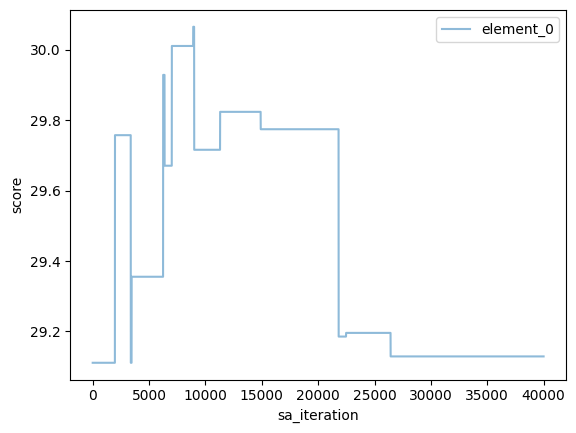

In [14]:
# To visualize whether the scores decreased appropriately, you can use matplotlib to create a plot.

import matplotlib.pyplot as plt
for idx, elem in enumerate(log_scores):
    plt.plot(elem, label=f'element_{idx}', alpha=0.5)
plt.xlabel('sa_iteration')
plt.ylabel('score')
plt.legend()
plt.show()

